# Notebook for Codementor Machine Learning Class 2
## U.S. Dept. of Education College Scorecard

### Topics
  * Data Science career discussion
  * Incorporate insights from data characterization (Class 1)
  * Principle Components Analysis (PCA)
  * K-means clustering on transformed (PCA) data
  * Provide a prototype useful to an engineer
  

### Career Discussion

  * Now that we've examined and characterized our client's data, we'll need to quickly create and deliver a prototype product.  Start quickly, fail fast, fail often.  (Engineering wisdom.)  We accept that all models are wrong, but some are useful.  Each time we create a product, we test and determine its value.  We envision a better product, throw away the old one, and build the new one.

  * In general, your clients will not be interested in your notebooks, your prototypes, your graphs, your studies, etc.  (Your data science colleagues will appreciate these things, but your clients/management want results.)  It is extremely important to your success as a data scientist to find out exactly what your client wants.  It is your job to provide it.

  * For our purposes, let's assume we are working with our client's engineer who will provide us with an input query in JSON (JavaScript Object Notation).  Example: { "home_state": "NJ", "major": "engineering", "math": 600, "verbal": 620, "writing": 580, "out_of_state": false, "budget": 30000}.  We are to provide useful information about recommended academic colleges and universities in return, in JSON.
  
  * We have not yet developed an engine which uses _all_ of the input data.  However, in this case we feel it is important to provide something quickly.  This way our engineer can get to work.  Then, we can continue to develop the engine and provide updates.  We'll also get feedback.  This way, we can change or modify our course if necessary.

### 1. Load and prepare raw data

In [1]:
%matplotlib inline
# allows plotting in cells, we'll use later on.
import pylab
pylab.rcParams['figure.figsize'] = (10, 6) # set a larger figure size

In [2]:
import sqlite3
conn = sqlite3.connect('C:/Users/peter/Documents/Codementor/MLClass/data/college/database.sqlite')

In [3]:
import pandas

In [4]:
query = """
SELECT UNITID,
       INSTNM,
       CONTROL as type,
       COSTT4_A AvgYrCostAcademic,
       COSTT4_P AvgYrCostProgram,
       md_earn_wne_p10 medEarn10yrs,
       md_earn_wne_p6 medEarn6yrs,
       Year,
       UGDS NumStudents,
       SATMTMID Math,
       SATVRMID Verbal,
       SATWRMID Writing,
       STABBR State,
       GRAD_DEBT_MDN DebtAtGrad,
       C150_4 completionRate
       
FROM Scorecard
WHERE Year='{0}'
"""
# I found that 2011 is the latest year with earnings data!
# Plan: use 2013 cost and 2011 earnings.  
# Earnings have been approximately flat in adjusted dollars for the past decade;
# so we'll just need to adjust 2011 dollars to 2013 dollars at some point
df2013 = pandas.read_sql(query.format(2013), conn)
df2011 = pandas.read_sql(query.format(2011), conn)


#### Index by the unique identifier (but remember, it is not a requirement that indices have unique values for each row)

In [5]:
df2011.set_index(['UNITID'], inplace=True)  
df2013.set_index(['UNITID'], inplace=True)

#### Create the numeric earnings column (year 2011 data) and add our computed SAT column (year 2013 data). 

In [7]:
df2011['earn10'] = pandas.to_numeric(df2011['medEarn10yrs'], errors='coerce')
df2013['sat'] = df2013['Math'] + df2013['Verbal']

Using Pandas.concat, let's tack on the 2011 earnings data to our 2013 dataframe.  This is done by matching UNITIDs.  In SQL, this would be an inner join and we'd have to explicitly state the join variable (UNITID) in each table.  In Pandas, it's assumed we'll join on the DataFrame/Series index (and we are free to state otherwise).  The Pandas concat function handles the join. 

In [8]:
dfearn = df2011['earn10'].dropna()
dfearn.head() # note the Series retains the UNITID index

UNITID
100654    31400.0
100663    40300.0
100690    38100.0
100706    46600.0
100724    27800.0
Name: earn10, dtype: float64

In [9]:
type(dfearn)

pandas.core.series.Series

In [10]:
# before
df2013.columns

Index([u'INSTNM', u'type', u'AvgYrCostAcademic', u'AvgYrCostProgram',
       u'medEarn10yrs', u'medEarn6yrs', u'Year', u'NumStudents', u'Math',
       u'Verbal', u'Writing', u'State', u'DebtAtGrad', u'completionRate',
       u'sat'],
      dtype='object')

In [11]:
df_joined = pandas.concat([df2013, dfearn], axis=1, join='inner')  # equivalent to sql inner join on UNITID

In [12]:
# after

df_joined.columns

Index([u'INSTNM', u'type', u'AvgYrCostAcademic', u'AvgYrCostProgram',
       u'medEarn10yrs', u'medEarn6yrs', u'Year', u'NumStudents', u'Math',
       u'Verbal', u'Writing', u'State', u'DebtAtGrad', u'completionRate',
       u'sat', u'earn10'],
      dtype='object')

#### Raw data prep complete: df_joined

In [13]:
df_joined.head()

,INSTNM,type,AvgYrCostAcademic,AvgYrCostProgram,medEarn10yrs,medEarn6yrs,Year,NumStudents,Math,Verbal,Writing,State,DebtAtGrad,completionRate,sat,earn10
UNITID,,,,,,,,,,,,,,,,
100654,Alabama A & M University,Public,18888.0,NaN,None,None,2013,4051.0,400.0,410.0,NaN,AL,33611.5,0.2914,810.0,31400.0
100663,University of Alabama at Birmingham,Public,19990.0,NaN,None,None,2013,11200.0,585.0,580.0,NaN,AL,23117,0.5377,1165.0,40300.0
100690,Amridge University,Private nonprofit,12300.0,NaN,None,None,2013,322.0,NaN,NaN,NaN,AL,26995,0.6667,NaN,38100.0
100706,University of Alabama in Huntsville,Public,20306.0,NaN,None,None,2013,5525.0,580.0,575.0,NaN,AL,24738,0.4835,1155.0,46600.0
100724,Alabama State University,Public,17400.0,NaN,None,None,2013,5354.0,425.0,430.0,NaN,AL,33452,0.2517,855.0,27800.0


### 2.  Principle Components Analysis (PCA)

Reference: http://scikit-learn.org/stable/modules/decomposition.html#pca

PCA is a _dimensionality reduction_ technique.  Dimensionality reduction means we have data that are redundant/related in some way, and we want to simplify things.  In our case, we have already seen our variables are correlated.  High incoming SAT scores are related to higher graduation rates.  So let's see if we can distill our 4 variables down to one or two.

From Wikipedia: "PCA is mathematically defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on."

#### Select our 4 numeric variables

In [15]:
dfc = df_joined[['sat', 'AvgYrCostAcademic', 'earn10', 'completionRate']].dropna()

#### Scale, to put all variables on equal footing, numerically

In [16]:
from sklearn.preprocessing import scale
dfscale = pandas.DataFrame(scale(dfc), index=dfc.index).rename(columns={0:'sat_scaled', 1:'cost', 2:'earn', 3:'gradrate'})

#### Apply PCA to our scaled data

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca_array = pca.fit_transform(dfscale[[u'sat_scaled', u'cost', u'earn', u'gradrate']])

In [18]:
dfscale.head()

,sat_scaled,cost,earn,gradrate
UNITID,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584
100663,0.805767,-1.019907,-0.288142,-0.093461
100706,0.732752,-0.995382,0.323949,-0.402448
100724,-1.457712,-1.220923,-1.502608,-1.723908
100751,0.513705,-0.497811,-0.084111,0.640811


In [19]:
type(pca_array)

numpy.ndarray

In [20]:
pca_array[0:5]

array([[-2.80131189,  0.09135926, -0.29349315,  0.20677773],
       [-0.2081237 , -0.92012765,  0.79199643, -0.51383194],
       [-0.11131329, -1.14392882,  0.16525396, -0.66809023],
       [-2.96677979,  0.09173086,  0.04900218, -0.18074187],
       [ 0.36158771, -0.54634494,  0.68725818,  0.16691281]])

Let's see how well the PCA went:

In [21]:
pca.explained_variance_ratio_

array([ 0.71100281,  0.14366243,  0.10260983,  0.04272492])

In [22]:
# the transformation matrix it came up with, for linear algebra fans:
pca.components_

array([[ 0.53299838,  0.44054527,  0.47765635,  0.54191975],
       [-0.23089238,  0.85534793, -0.45941213, -0.06331768],
       [ 0.4484766 , -0.24949521, -0.74793387,  0.42097008],
       [-0.67931597, -0.10978127,  0.03714616,  0.7246365 ]])

We have a happy case where we can pack most of the useful information (71 + 14 = 85%) into the first two PCA variables.  This means we can cluster using only the first two PCA variables and visualize it completely in a 2-D chart.

Let's have a look at our transformed variables, which we assigned to `pca_array`:

In [23]:
pca_array[0:20]

array([[-2.80131189,  0.09135926, -0.29349315,  0.20677773],
       [-0.2081237 , -0.92012765,  0.79199643, -0.51383194],
       [-0.11131329, -1.14392882,  0.16525396, -0.66809023],
       [-2.96677979,  0.09173086,  0.04900218, -0.18074187],
       [ 0.36158771, -0.54634494,  0.68725818,  0.16691281],
       [ 0.59556774, -0.94671243,  0.68743474,  0.05675819],
       [ 0.91744624,  0.62379752,  0.36373427, -0.33071202],
       [-1.16786845,  0.39986375, -0.18773636,  0.05606748],
       [-1.96344061, -0.3203564 , -0.02032533, -0.48153801],
       [-0.87357919,  0.10941743,  0.95436227, -1.06372723],
       [-0.31890688, -0.03548538,  0.50049751, -0.55645963],
       [-1.11590653, -0.46793198,  0.6161938 , -0.38876446],
       [-1.98500198, -0.66393564,  0.02428381, -0.41671612],
       [-1.51553187,  0.83240978, -0.24421418, -0.15380407],
       [ 1.01248856,  0.0971483 ,  0.26673582,  0.18127575],
       [-1.6891846 , -0.66099666, -0.05224733, -0.49409967],
       [ 0.50015016,  0.

Let's look at our transformed data alongside the original data:

In [24]:
dfscale['PCA0'] = pca_array[:,0]
dfscale['PCA1'] = pca_array[:,1]
dfscale['PCA2'] = pca_array[:,2]
dfscale['PCA3'] = pca_array[:,3]
dfscale.head(10) # shows data before PCA (left 4 columns) and after PCA (right 4 columns)

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3
UNITID,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913
100858,0.805767,-0.725137,0.207361,0.713212,0.595568,-0.946712,0.687435,0.056758
100937,0.732752,0.883297,-0.132690,0.371160,0.917446,0.623798,0.363734,-0.330712
101435,-0.837080,-0.131792,-0.599045,-0.696612,-1.167868,0.399864,-0.187736,0.056067
101480,-0.654542,-1.081066,-0.793360,-1.401239,-1.963441,-0.320356,-0.020325,-0.481538


In [25]:
dfscale.describe()

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3
count,1.237000e+03,1.237000e+03,1.237000e+03,1.237000e+03,1.237000e+03,1.237000e+03,1.237000e+03,1.237000e+03
mean,7.848074e-16,1.425250e-16,3.508601e-16,-6.821993e-16,6.435165e-17,6.192837e-18,-1.348513e-17,-2.288657e-17
std,1.000404e+00,1.000404e+00,1.000404e+00,1.000404e+00,1.687102e+00,7.583631e-01,6.409145e-01,4.135673e-01
min,-3.319605e+00,-1.805031e+00,-2.493612e+00,-2.882895e+00,-4.246290e+00,-2.791163e+00,-5.029245e+00,-2.066555e+00
25%,-6.545418e-01,-9.103191e-01,-6.476236e-01,-7.142850e-01,-1.147450e+00,-5.915854e-01,-3.573900e-01,-2.642754e-01
50%,-1.434337e-01,-3.299192e-02,-1.618372e-01,-6.723658e-02,-2.848807e-01,1.673621e-01,3.048090e-02,9.247223e-03
75%,4.771975e-01,7.253559e-01,4.113908e-01,6.482222e-01,8.835487e-01,5.740212e-01,4.077402e-01,2.697495e-01
max,3.580354e+00,2.286679e+00,7.105528e+00,2.416061e+00,5.956233e+00,2.450904e+00,1.722452e+00,1.367887e+00


### 3. Clustering (via Kmeans)

Create an instance of the clustering object

In [26]:
from sklearn.cluster import KMeans
km = KMeans(init='k-means++', n_clusters=7)

Cluster using just PCA0 and PCA1.  Store the cluster numbers in our dataframe.

In [27]:

dfscale['KM_PCA_cluster'] = km.fit_predict(dfscale[['PCA0','PCA1']])

For purposes of comparision, cluster will all the original data:

In [28]:
dfscale['KM_cluster'] = km.fit_predict(dfscale[['sat_scaled', 'cost', 'earn', 'gradrate']])

In [29]:
dfscale.head()

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_PCA_cluster,KM_cluster
UNITID,,,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778,1,4
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832,4,3
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090,4,3
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742,1,4
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913,4,3


Let's have a look!  First, clustering on PCA0 and PCA1 only:

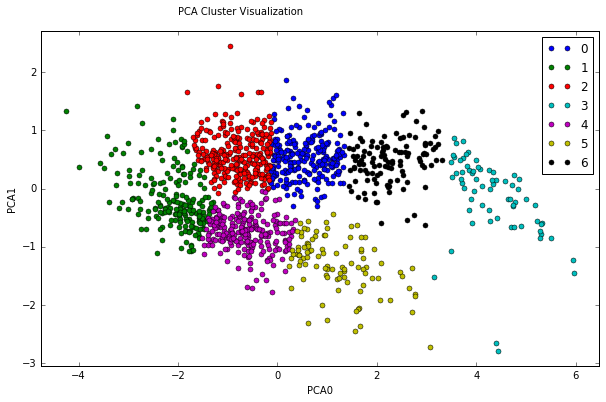

In [30]:
import matplotlib.pyplot as plt

groups = dfscale.groupby('KM_PCA_cluster')

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.PCA0, group.PCA1, marker='o', linestyle='', ms=5, label=name)
ax.legend()
ax.set_xlabel("PCA0")
ax.set_ylabel("PCA1")
ax.text(-2, 3, 'PCA Cluster Visualization')

plt.show()

In [33]:
groups

In [34]:
groups.median().sort_values(by='sat_scaled')  # bottom cluster is the low-cost group!

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_cluster
KM_PCA_cluster,,,,,,,,,
1,-0.946604,-1.109394,-0.880801,-1.227363,-1.971373,-0.302375,-0.012209,-0.180742,4
2,-0.618034,0.117886,-0.589329,-0.543259,-0.789297,0.553331,-0.149312,0.005333,1
4,-0.143434,-0.977376,-0.113259,-0.251375,-0.632456,-0.739771,0.202438,0.044472,3
0,0.112120,0.661714,-0.025817,0.356908,0.538715,0.517994,0.040142,0.080429,0
5,0.915290,-0.731850,0.746583,0.964620,0.995156,-1.283422,0.496172,0.237667,5
6,1.024813,1.390181,0.863172,1.239117,2.191726,0.497454,-0.027102,0.004664,6
3,2.448614,1.967460,2.208801,2.059757,4.261555,0.008039,-0.174083,-0.382132,2


Let's see how clustering with the raw data compared to clustering PCA-transformed variables.

In [35]:
groups_raw = dfscale.groupby('KM_cluster')
groups_raw.median().sort_values(by='sat_scaled') 

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_PCA_cluster
KM_cluster,,,,,,,,,
4,-0.946604,-1.109394,-0.880801,-1.229643,-1.970424,-0.302375,-0.017764,-0.182898,1
1,-0.654542,0.176289,-0.501888,-0.561502,-0.763974,0.568416,-0.234845,-0.042793,2
3,-0.165338,-0.953937,-0.171553,-0.229141,-0.658686,-0.704756,0.246001,0.061654,4
0,0.126723,0.658299,-0.064680,0.392823,0.579410,0.514974,0.111147,0.103991,0
5,0.915290,-0.734062,0.693147,0.945807,0.989261,-1.275901,0.515200,0.234092,5
6,1.061321,1.410127,0.819451,1.291850,2.213076,0.559920,0.045081,-0.011931,6
2,2.412107,1.945651,2.373968,2.030682,4.270777,-0.179981,-0.309273,-0.380143,3


The median values of the clusters are nearly the same.  Not much difference, so far.  What about visualization?  Well, the first problem is: what do we graph on each axis?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C81D518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000EE04860>]], dtype=object)

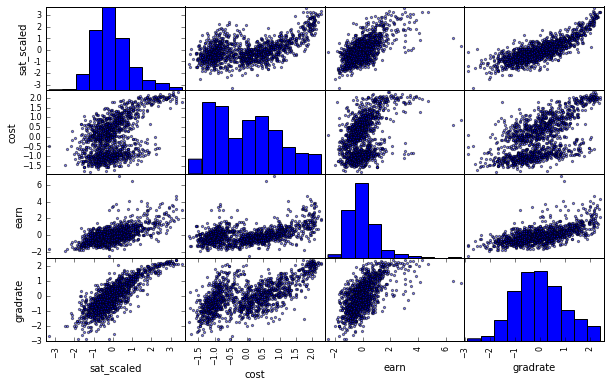

In [36]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(dfscale[['sat_scaled', 'cost', 'earn', 'gradrate']])

Let's try one that already shows distinct groups, such as cost vs. gradrate.

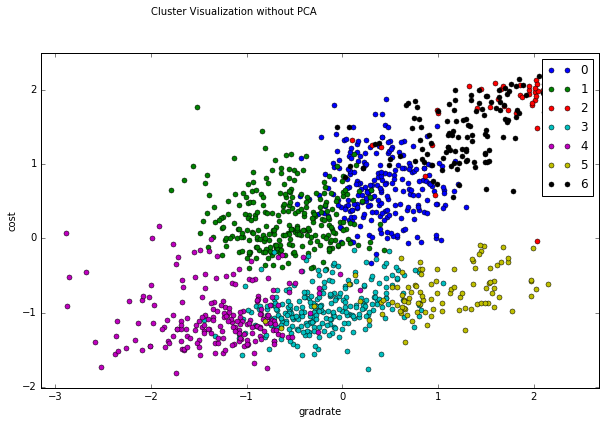

In [37]:
groups = dfscale.groupby('KM_cluster')

fig, ax = plt.subplots()
ax.margins(0.05) 
for name, group in groups:
    ax.plot(group.gradrate, group.cost, marker='o', linestyle='', ms=5, label=name)
ax.legend()
ax.set_xlabel("gradrate")
ax.set_ylabel("cost")
ax.text(-2, 3, 'Cluster Visualization without PCA')


plt.show()

Not too bad-- but still a bit of a mess compared to our PCA.  There, the clustering algorithm ran on two dimensional data.  Here, it made 4-dimensional clusters.  If you feel like you should be able peek your head around the side of the graph to get a better view of the clusters, PCA is exactly that; a transformation of variables.  It transforms in such as way as to pack as much information as possible into the first PCA variable, then the second, and so on.  That is why PCA is referred to as a "dimensionality reduction" technique.  You can also think of clustering as a dimensionality reduction technque, where we map down to one categorical dimension (cluster number).

### 4.  Prototype construction using the clustered data

Back to business-- my plan for a prototype product-- (yours could be different, and better).  Let's take the SAT score and align it to the nearest cluster median.  We'll return three schools from that cluster within the budget.  Then we'll take three schools from the cluster above ("reach schools") and below ("safe schools").  If we're in the top or bottom cluster to begin with, we'll return 3 additional schools from the matching cluster.  So that we can easily get the cluster above and below, let's also re-map the cluster numbers.

#### Re-map cluster numbers.  Right now the numbers don't mean anything.  
Let's make cluster 0 correspond to the lowest median SAT scores,
cluster 1 to the next highest, etc., cluster 6 to the highest.
Save the new meaningful cluster number in our dataframe as `cluster ordinal`.

In [46]:
groups = dfscale.groupby('KM_PCA_cluster')
cluster_number_map = groups.median().sort_values(by='sat_scaled').index  # cluster numbers sorted from lowest to highest SAT
cluster_number_map

Int64Index([1, 2, 4, 0, 5, 6, 3], dtype='int64', name=u'KM_PCA_cluster')

In [48]:
d = { cluster_number_map[i]: i for i in range(7) }
d

{0: 3, 1: 0, 2: 1, 3: 6, 4: 2, 5: 4, 6: 5}

In [60]:
d[6]

5

In [61]:
d[2]

1

In [53]:
cluster_ord = dfscale.KM_PCA_cluster.map(lambda x: d[x])
cluster_ord.head(10)

UNITID
100654    0
100663    2
100706    2
100724    0
100751    2
100858    4
100937    3
101435    1
101480    0
101541    1
Name: KM_PCA_cluster, dtype: int64

In [52]:
cluster_ord = dfscale.KM_PCA_cluster.map(lambda x: d[x])
dfscale['cluster_ordinal'] = cluster_ord
dfscale.head()

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_PCA_cluster,KM_cluster,cluster_ordinal
UNITID,,,,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778,1,4,0
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832,4,3,2
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090,4,3,2
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742,1,4,0
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913,4,3,2


In [45]:
groups = dfscale.groupby('KM_PCA_cluster')
groups.median().sort_values(by='sat_scaled')

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_cluster,cluster_ordinal
KM_PCA_cluster,,,,,,,,,,
1,-0.946604,-1.109394,-0.880801,-1.227363,-1.971373,-0.302375,-0.012209,-0.180742,4,0
2,-0.618034,0.117886,-0.589329,-0.543259,-0.789297,0.553331,-0.149312,0.005333,1,1
4,-0.143434,-0.977376,-0.113259,-0.251375,-0.632456,-0.739771,0.202438,0.044472,3,2
0,0.112120,0.661714,-0.025817,0.356908,0.538715,0.517994,0.040142,0.080429,0,3
5,0.915290,-0.731850,0.746583,0.964620,0.995156,-1.283422,0.496172,0.237667,5,4
6,1.024813,1.390181,0.863172,1.239117,2.191726,0.497454,-0.027102,0.004664,6,5
3,2.448614,1.967460,2.208801,2.059757,4.261555,0.008039,-0.174083,-0.382132,2,6


#### Side lesson:  What's a lambda function??

In [54]:
def add_three(x):
    return x + 3

In [55]:
add_three(10)

13

In [56]:
def foo(some_fun):
    print "you passed", some_fun
    print "I will now put 10 in that function"
    print some_fun(10)

In [57]:
foo(add_three)

you passed <function add_three at 0x000000000ED27048>
I will now put 10 in that function
13


In [58]:
foo(lambda x: x + 3)

you passed <function <lambda> at 0x000000000ED80C18>
I will now put 10 in that function
13


In [59]:
foo(lambda x: 2*x)

you passed <function <lambda> at 0x000000000ED80C18>
I will now put 10 in that function
20


#### *end of side lesson on lambda functions*

Design decision: let's work with unscaled cost and SAT scores.  This way we do not have to scale incoming data.  Since we've retained the school IDs, we simply need to bring our cluster labels back to the raw dataframe.  Let's see how this would work in the notebook, then code up the prototype as a python command-line program.

In [62]:
df_joined.head()

,INSTNM,type,AvgYrCostAcademic,AvgYrCostProgram,medEarn10yrs,medEarn6yrs,Year,NumStudents,Math,Verbal,Writing,State,DebtAtGrad,completionRate,sat,earn10
UNITID,,,,,,,,,,,,,,,,
100654,Alabama A & M University,Public,18888.0,NaN,None,None,2013,4051.0,400.0,410.0,NaN,AL,33611.5,0.2914,810.0,31400.0
100663,University of Alabama at Birmingham,Public,19990.0,NaN,None,None,2013,11200.0,585.0,580.0,NaN,AL,23117,0.5377,1165.0,40300.0
100690,Amridge University,Private nonprofit,12300.0,NaN,None,None,2013,322.0,NaN,NaN,NaN,AL,26995,0.6667,NaN,38100.0
100706,University of Alabama in Huntsville,Public,20306.0,NaN,None,None,2013,5525.0,580.0,575.0,NaN,AL,24738,0.4835,1155.0,46600.0
100724,Alabama State University,Public,17400.0,NaN,None,None,2013,5354.0,425.0,430.0,NaN,AL,33452,0.2517,855.0,27800.0


In [63]:
dfscale.head()

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_PCA_cluster,KM_cluster,cluster_ordinal
UNITID,,,,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778,1,4,0
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832,4,3,2
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090,4,3,2
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742,1,4,0
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913,4,3,2


In [64]:
df_out = pandas.concat([dfscale, df_joined], axis=1, join='inner')
df_out.head()

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_PCA_cluster,KM_cluster,...,Year,NumStudents,Math,Verbal,Writing,State,DebtAtGrad,completionRate,sat,earn10
UNITID,,,,,,,,,,,,,,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778,1,4,...,2013,4051.0,400.0,410.0,NaN,AL,33611.5,0.2914,810.0,31400.0
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832,4,3,...,2013,11200.0,585.0,580.0,NaN,AL,23117,0.5377,1165.0,40300.0
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090,4,3,...,2013,5525.0,580.0,575.0,NaN,AL,24738,0.4835,1155.0,46600.0
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742,1,4,...,2013,5354.0,425.0,430.0,NaN,AL,33452,0.2517,855.0,27800.0
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913,4,3,...,2013,28692.0,570.0,555.0,540.0,AL,24000,0.6665,1125.0,42400.0


In [65]:
df_out.columns

Index([u'sat_scaled', u'cost', u'earn', u'gradrate', u'PCA0', u'PCA1', u'PCA2',
       u'PCA3', u'KM_PCA_cluster', u'KM_cluster', u'cluster_ordinal',
       u'INSTNM', u'type', u'AvgYrCostAcademic', u'AvgYrCostProgram',
       u'medEarn10yrs', u'medEarn6yrs', u'Year', u'NumStudents', u'Math',
       u'Verbal', u'Writing', u'State', u'DebtAtGrad', u'completionRate',
       u'sat', u'earn10'],
      dtype='object')

In [66]:
out_groups = df_out[['cluster_ordinal','sat','AvgYrCostAcademic','earn10', 'completionRate']].groupby('cluster_ordinal')
df_cluster_lookup = out_groups.median()
df_cluster_lookup

,sat,AvgYrCostAcademic,earn10,completionRate
cluster_ordinal,,,,
0,925.0,18837.0,34200.0,0.33880
1,970.0,34650.0,37200.0,0.45880
2,1035.0,20538.0,42100.0,0.51000
3,1070.0,41657.0,43000.0,0.61670
4,1180.0,23701.5,50950.0,0.72330
5,1195.0,51043.0,52150.0,0.77145
6,1390.0,58481.0,66000.0,0.91540


There is a handy pandas function for our purposes called 'argsort'.  We can use it to return the closest clusters to our query SAT score, in order.

In [67]:
query_sat = 1100
(df_cluster_lookup.sat - query_sat).abs()

cluster_ordinal
0    175.0
1    130.0
2     65.0
3     30.0
4     80.0
5     95.0
6    290.0
Name: sat, dtype: float64

In [68]:
(df_cluster_lookup.sat - query_sat).abs().argsort()

cluster_ordinal
0    3
1    2
2    4
3    5
4    1
5    0
6    6
Name: sat, dtype: int64

In [69]:
(df_cluster_lookup.sat - query_sat).abs().argsort()[0]

3

In [72]:

df_cluster_lookup.iloc[(df_cluster_lookup.sat - query_sat).abs().argsort()[:1]]

,sat,AvgYrCostAcademic,earn10,completionRate
cluster_ordinal,,,,
3,1070.0,41657.0,43000.0,0.6167


I still like having ordinal labels for the clusters-- it clearly validates our argsort technique.  Now, let's get to picking out some schools, given a cluster and a budget. 

In [73]:
query_sat = 1100
query_maxcost = 40000
query_sat_add_max = 10
query_cluster = 3 # got this with argsort above

c1 = df_out['cluster_ordinal'] == query_cluster
c2 = df_out['AvgYrCostAcademic'] <= query_maxcost
c3 = df_out['sat'] <= query_sat + query_sat_add_max
condition = c1 & c2 & c3

df_out.loc[condition].sort_values(by='sat', ascending=False)[0:3]

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_PCA_cluster,KM_cluster,...,Year,NumStudents,Math,Verbal,Writing,State,DebtAtGrad,completionRate,sat,earn10
UNITID,,,,,,,,,,,,,,,,,,,,,
230807,0.404182,0.377110,0.217076,0.098659,0.538715,0.123264,-0.033647,-0.236412,0,0,...,2013,2260.0,555.0,555.0,NaN,UT,24500,0.5714,1110.0,45500.0
191676,0.389579,0.405206,-0.395015,1.051844,0.767490,0.371516,0.811860,0.438400,0,0,...,2013,1047.0,548.0,560.0,535.0,NY,23500,0.7386,1108.0,39200.0
239512,0.374976,0.465045,-1.104263,0.126023,-0.054429,0.810528,0.931109,-0.255479,0,0,...,2013,546.0,548.0,558.0,NaN,WI,27000,0.5762,1106.0,31900.0


Really we just need the UNITIDS

In [74]:
df_out.loc[condition].sort_values(by='sat', ascending=False)[0:3].index

Int64Index([230807, 191676, 239512], dtype='int64', name=u'UNITID')

In [75]:
picks = df_out.loc[condition].sort_values(by='sat', ascending=False)[0:5].index

df_response = df_joined.loc[picks, 
    ['INSTNM', 'type', 'NumStudents', 'AvgYrCostAcademic', 'sat', 'earn10']]
df_response

,INSTNM,type,NumStudents,AvgYrCostAcademic,sat,earn10
UNITID,,,,,,
230807,Westminster College,Private nonprofit,2260.0,37990.0,1110.0,45500.0
191676,Houghton College,Private nonprofit,1047.0,38352.0,1108.0,39200.0
239512,Northland College,Private nonprofit,546.0,39123.0,1106.0,31900.0
227863,University of St Thomas,Private nonprofit,1529.0,37271.0,1105.0,48800.0
188641,Alfred University,Private nonprofit,1905.0,38830.0,1100.0,42300.0


In [76]:
df_response.to_json(orient='records')

'[{"INSTNM":"Westminster College","type":"Private nonprofit","NumStudents":2260.0,"AvgYrCostAcademic":37990.0,"sat":1110.0,"earn10":45500.0},{"INSTNM":"Houghton College","type":"Private nonprofit","NumStudents":1047.0,"AvgYrCostAcademic":38352.0,"sat":1108.0,"earn10":39200.0},{"INSTNM":"Northland College","type":"Private nonprofit","NumStudents":546.0,"AvgYrCostAcademic":39123.0,"sat":1106.0,"earn10":31900.0},{"INSTNM":"University of St Thomas","type":"Private nonprofit","NumStudents":1529.0,"AvgYrCostAcademic":37271.0,"sat":1105.0,"earn10":48800.0},{"INSTNM":"Alfred University","type":"Private nonprofit","NumStudents":1905.0,"AvgYrCostAcademic":38830.0,"sat":1100.0,"earn10":42300.0}]'

In [77]:
df_response.to_json()

'{"INSTNM":{"230807":"Westminster College","191676":"Houghton College","239512":"Northland College","227863":"University of St Thomas","188641":"Alfred University"},"type":{"230807":"Private nonprofit","191676":"Private nonprofit","239512":"Private nonprofit","227863":"Private nonprofit","188641":"Private nonprofit"},"NumStudents":{"230807":2260.0,"191676":1047.0,"239512":546.0,"227863":1529.0,"188641":1905.0},"AvgYrCostAcademic":{"230807":37990.0,"191676":38352.0,"239512":39123.0,"227863":37271.0,"188641":38830.0},"sat":{"230807":1110.0,"191676":1108.0,"239512":1106.0,"227863":1105.0,"188641":1100.0},"earn10":{"230807":45500.0,"191676":39200.0,"239512":31900.0,"227863":48800.0,"188641":42300.0}}'

In [118]:
pandas.DataFrame.to_json?